## SEE_PY

- Zeus Elderfield
- Earl Rondina

## Instructions

Assignment 2 For Clustering: Sessa Empirical Estimator
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2025 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

## Import Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import os
import warnings

## Config

In [30]:
os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore")

### Import dataset

In [31]:
# Simulated data is based from med.events
simulated_df = pd.read_csv('../data/med_events.csv')

simulated_df.tail()

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
1075,100,03/05/2034,6,medB,30
1076,100,04/07/2034,6,medB,30
1077,100,04/26/2034,6,medB,30
1078,100,05/26/2034,6,medB,30
1079,100,07/09/2034,4,medB,30


### Change column names to match R function

In [32]:
cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]

simulated_df.columns = cols

simulated_df.head()

,pnr,eksd,perday,ATC,dur_original
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30



### Convert eksd string to DateTime

In [33]:
simulated_df['eksd'] = pd.to_datetime(simulated_df['eksd'])

simulated_df.head()

,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


### Exploratory Data Analysis

#### I. Basic Information

In [34]:
simulated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pnr           1080 non-null   int64         
 1   eksd          1080 non-null   datetime64[ns]
 2   perday        1080 non-null   int64         
 3   ATC           1080 non-null   object        
 4   dur_original  1080 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 42.3+ KB


#### II. Check for missing values

In [35]:
simulated_df.isna().sum()

pnr             0
eksd            0
perday          0
ATC             0
dur_original    0
dtype: int64

#### III. Descriptive Statistics

In [36]:
simulated_df.describe()

,pnr,eksd,perday,dur_original
count,1080.000000,1080,1080.000000,1080.00000
mean,50.934259,2038-01-29 22:02:40,3.762963,47.37963
min,1.000000,2030-09-06 00:00:00,2.000000,20.00000
25%,24.000000,2035-06-03 06:00:00,2.000000,30.00000
50%,51.500000,2037-09-03 12:00:00,4.000000,50.00000
75%,78.000000,2041-05-05 00:00:00,4.000000,50.00000
max,100.000000,2044-09-03 00:00:00,20.000000,150.00000
std,29.999542,NaN,2.139552,22.08091


#### IV. Distribution of 'perday'

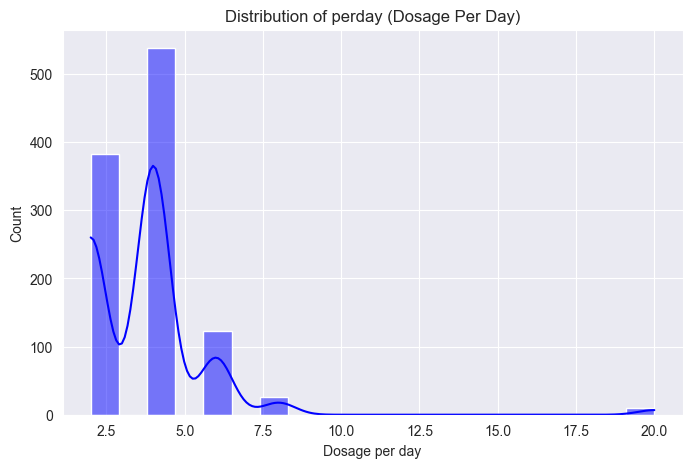

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(simulated_df['perday'], bins=20, kde=True, color='blue')
plt.title('Distribution of perday (Dosage Per Day)')
plt.xlabel('Dosage per day')
plt.ylabel('Count')
plt.show()


#### V. Distribution of 'dur_original'

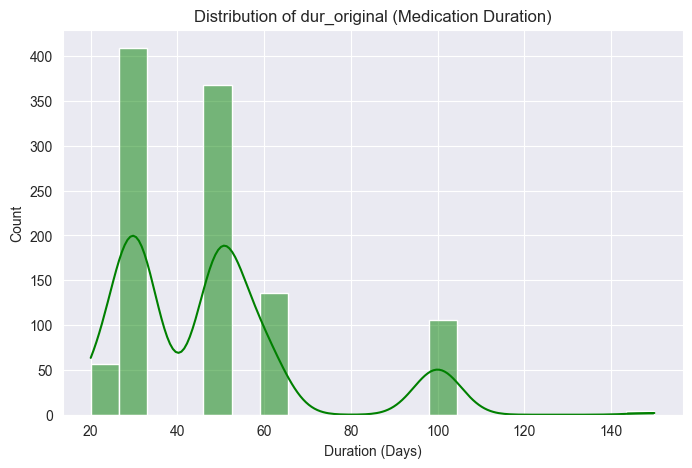

In [38]:
plt.figure(figsize=(8, 5))
sns.histplot(simulated_df['dur_original'], bins=20, kde=True, color='green')
plt.title('Distribution of dur_original (Medication Duration)')
plt.xlabel('Duration (Days)')
plt.ylabel('Count')
plt.show()

#### VI. Count of unique values in 'ATC'

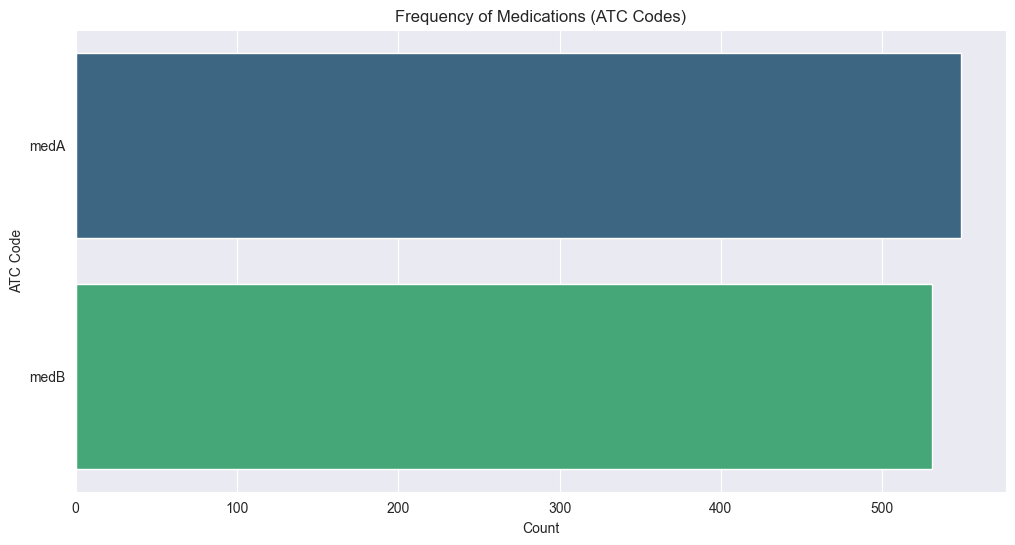

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(y=simulated_df['ATC'], order=simulated_df['ATC'].value_counts().index, palette="viridis")
plt.title('Frequency of Medications (ATC Codes)')
plt.xlabel('Count')
plt.ylabel('ATC Code')
plt.show()

#### VII. Trend of medication start dates over time

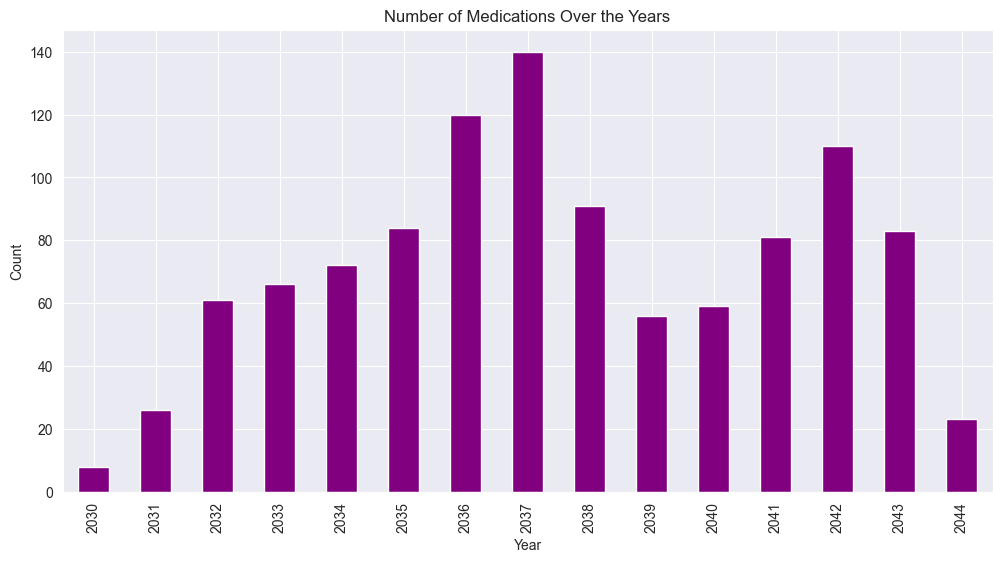

In [40]:
plt.figure(figsize=(12, 6))
simulated_df['eksd'].dt.year.value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Number of Medications Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

#### VIII. Boxplots to check outliers

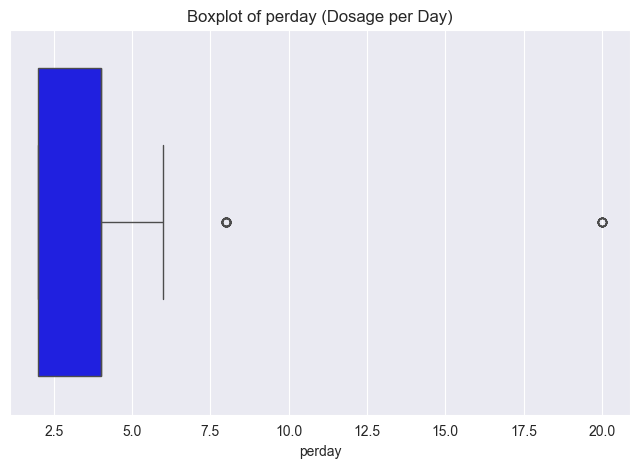

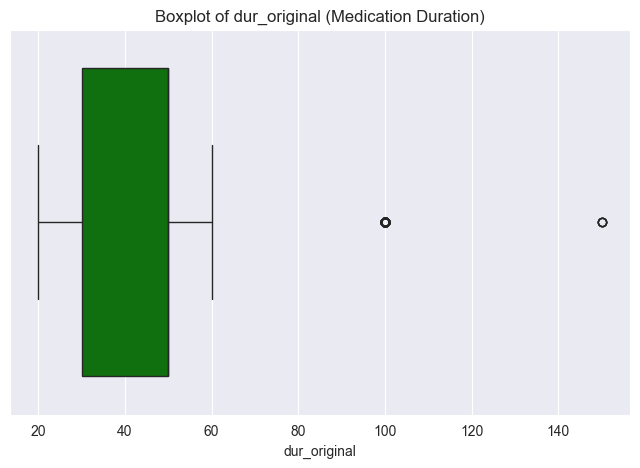

In [41]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=simulated_df['perday'], color='blue')
plt.title('Boxplot of perday (Dosage per Day)')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=simulated_df['dur_original'], color='green')
plt.title('Boxplot of dur_original (Medication Duration)')
plt.show()

#### IX. Correlation Heatmap

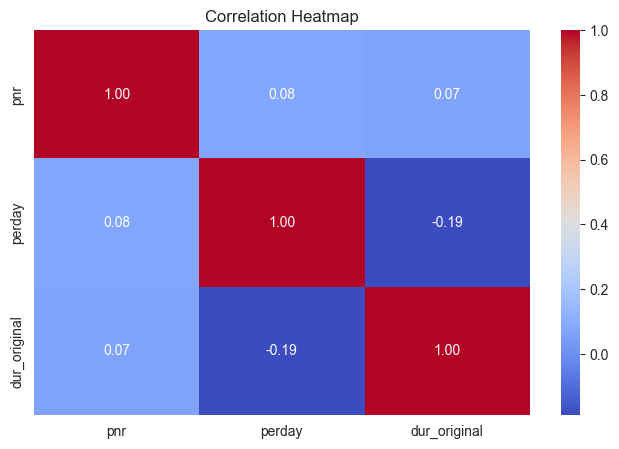

In [42]:
plt.figure(figsize=(8, 5))
sns.heatmap(simulated_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Define Function/s

#### I. Sessa Empirical Estimator using K-means clustering

In [43]:
def See_KMeans(arg1, tidy):
    # Filter rows where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Make working copies
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()

    # Sort by 'pnr' and 'eksd' and create a lag of 'eksd' by group 'pnr'
    Drug_see_p1.sort_values(by=['pnr', 'eksd'], inplace=True)
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])

    # For each pnr group, randomly sample one row
    Drug_see_p1 = Drug_see_p1.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1, random_state=1234))

    # Keep only needed columns
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']].copy()

    # Compute the event interval (if eksd is datetime, compute days; otherwise, assume numeric)
    if np.issubdtype(Drug_see_p1['eksd'].dtype, np.datetime64):
        Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    else:
        Drug_see_p1['event.interval'] = Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']
    Drug_see_p1['event.interval'] = pd.to_numeric(Drug_see_p1['event.interval'])

    # --- ECDF Generation ---
    # Compute the empirical CDF for event.interval
    sorted_intervals = np.sort(Drug_see_p1['event.interval'].values)
    n = len(sorted_intervals)
    yvals = np.arange(1, n+1) / n
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': yvals})

    # Retain the lower 80% of the ECDF
    dfper_80 = dfper[dfper['y'] <= 0.8].copy()
    ni = dfper_80['x'].max()  # maximum event interval in the 80% subset

    # Plot ECDFs
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(dfper_80['x'], dfper_80['y'])
    axs[0].set_title("80% ECDF")
    axs[0].set_xlabel("event.interval")
    axs[0].set_ylabel("ECDF")
    axs[1].scatter(dfper['x'], dfper['y'])
    axs[1].set_title("100% ECDF")
    axs[1].set_xlabel("event.interval")
    axs[1].set_ylabel("ECDF")
    plt.tight_layout()
    plt.show()

    # Plot frequency table for pnr counts
    m1 = Drug_see_p1['pnr'].value_counts()
    m1.plot(kind='bar', title="Frequency of pnr", figsize=(16, 6))
    plt.xlabel("pnr")
    plt.ylabel("Count")
    plt.show()

    # Subset to rows with event.interval <= ni (using the same dataframe as before)
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni].copy()

    # --- Density Estimation on Log(event.interval) ---
    log_intervals = np.log(Drug_see_p2['event.interval'].values)
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)

    plt.plot(x1, y1)
    plt.title("Density of log(event.interval)")
    plt.xlabel("log(event.interval)")
    plt.ylabel("Density")
    plt.show()

    # Prepare data for silhouette analysis: scale the density grid points
    a = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)

    # --- Silhouette Analysis to determine optimal number of clusters ---
    # Try clustering with k from 2 to 10 (or up to the number of points)
    best_k = 2
    best_score = -1
    max_k = min(10, len(a_scaled))
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    max_cluster = best_k

    # --- K-means Clustering on the ECDF x-values ---
    # Reshape x for clustering (one-dimensional)
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(dfper[['x']])

    # Compute summary statistics (min, max, median) on log(x) for each cluster
    dfper['log_x'] = np.log(dfper['x'])
    summary = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    # Replace any -infinity with 0 if necessary
    summary['min'] = summary['min'].replace(-np.inf, 0)
    # Exponentiate to return to original scale
    summary['Minimum'] = np.exp(summary['min'])
    summary['Maximum'] = np.exp(summary['max'])
    summary['Median'] = np.exp(summary['median'])
    # Keep clusters with a positive median
    summary = summary[summary['Median'] > 0]

    # --- Cross-join with Drug_see_p1 and assign a cluster if event.interval falls within the cluster bounds ---
    Drug_see_p1['key'] = 1
    summary['key'] = 1
    cross = pd.merge(Drug_see_p1, summary, on='key')
    cross['Final_cluster'] = np.where(
        (cross['event.interval'] >= cross['Minimum']) & (cross['event.interval'] <= cross['Maximum']),
        cross['cluster'],
        np.nan
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    # Keep only the needed columns (using the cluster from ECDF, not Final_cluster, as in the R code)
    results = results[['pnr', 'Median', 'cluster']]

    # --- Choose the cluster with the highest frequency ---
    if not results.empty:
        top_cluster = results['cluster'].value_counts().idxmax()
        t1 = results[results['cluster'] == top_cluster].iloc[[0]].copy()
    else:
        t1 = pd.DataFrame({'cluster': [0], 'Median': [np.nan]})

    # --- Merge cluster results back into Drug_see_p1 ---
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left', suffixes=('', '_res'))
    # Fill missing Median values with the top cluster’s median and missing clusters with 0
    top_median = t1['Median'].iloc[0] if not t1.empty else np.nan
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(top_median)
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0)
    # Compute a test column as the difference between event.interval and Median (rounded to one decimal)
    Drug_see_p1['test'] = np.round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)

    # Keep only pnr, Median, and cluster in a separate dataframe
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']].copy()

    # --- Merge back with the original copy (Drug_see_p0) ---
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(top_median)
    Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0)

    return Drug_see_p0


#### II. Sessa Empirical Estimator using DBSCAN

In [44]:
def See_DBSCAN(arg1, tidy):
    # Filter rows where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Make working copies
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()

    # Sort by 'pnr' and 'eksd' and create a lag of 'eksd' by group 'pnr'
    Drug_see_p1.sort_values(by=['pnr', 'eksd'], inplace=True)
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])

    # For each pnr group, randomly sample one row
    Drug_see_p1 = Drug_see_p1.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1, random_state=1234))

    # Keep only needed columns
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']].copy()

    # Compute the event interval (if eksd is datetime, compute days; otherwise, assume numeric)
    if np.issubdtype(Drug_see_p1['eksd'].dtype, np.datetime64):
        Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    else:
        Drug_see_p1['event.interval'] = Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']
    Drug_see_p1['event.interval'] = pd.to_numeric(Drug_see_p1['event.interval'])

    # --- ECDF Generation ---
    # Compute the empirical CDF for event.interval
    sorted_intervals = np.sort(Drug_see_p1['event.interval'].values)
    n = len(sorted_intervals)
    yvals = np.arange(1, n+1) / n
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': yvals})

    # Retain the lower 80% of the ECDF
    dfper_80 = dfper[dfper['y'] <= 0.8].copy()
    ni = dfper_80['x'].max()  # maximum event interval in the 80% subset

    # Plot ECDFs
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(dfper_80['x'], dfper_80['y'])
    axs[0].set_title("80% ECDF")
    axs[0].set_xlabel("event.interval")
    axs[0].set_ylabel("ECDF")
    axs[1].scatter(dfper['x'], dfper['y'])
    axs[1].set_title("100% ECDF")
    axs[1].set_xlabel("event.interval")
    axs[1].set_ylabel("ECDF")
    plt.tight_layout()
    plt.show()

    # Plot frequency table for pnr counts
    m1 = Drug_see_p1['pnr'].value_counts()
    m1.plot(kind='bar', title="Frequency of pnr", figsize=(16, 6))
    plt.xlabel("pnr")
    plt.ylabel("Count")
    plt.show()

    # Subset to rows with event.interval <= ni
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni].copy()

    # --- Density Estimation on Log(event.interval) ---
    log_intervals = np.log(Drug_see_p2['event.interval'].values)
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)

    plt.plot(x1, y1)
    plt.title("Density of log(event.interval)")
    plt.xlabel("log(event.interval)")
    plt.ylabel("Density")
    plt.show()

    # --- DBSCAN Clustering on the ECDF x-values ---
    # We cluster the one-dimensional ECDF x-values. First, scale the data.
    X = dfper[['x']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Grid search for optimal eps value
    best_eps = None
    best_score = -1
    eps_values = np.linspace(0.1, 2.0, 20)
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=5)
        labels = db.fit_predict(X_scaled)
        # Exclude noise points (-1) for silhouette scoring
        if len(set(labels)) - (1 if -1 in labels else 0) < 2:
            continue
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_eps = eps
    # Default eps if none produced valid clusters
    if best_eps is None:
        best_eps = 0.5

    # Run DBSCAN with the optimal eps
    db_final = DBSCAN(eps=best_eps, min_samples=5)
    labels_final = db_final.fit_predict(X_scaled)
    dfper['cluster'] = labels_final
    # Replace noise label (-1) with 0 for consistency
    dfper['cluster'] = dfper['cluster'].apply(lambda x: x if x != -1 else 0)

    # Compute summary statistics (min, max, median) on log(x) for each cluster
    dfper['log_x'] = np.log(dfper['x'])
    summary = dfper.groupby('cluster')['log_x'].agg(['min', 'max', 'median']).reset_index()
    summary['min'] = summary['min'].replace(-np.inf, 0)
    summary['Minimum'] = np.exp(summary['min'])
    summary['Maximum'] = np.exp(summary['max'])
    summary['Median'] = np.exp(summary['median'])
    summary = summary[summary['Median'] > 0]

    # --- Cross-join with Drug_see_p1 and assign a cluster if event.interval falls within the cluster bounds ---
    Drug_see_p1['key'] = 1
    summary['key'] = 1
    cross = pd.merge(Drug_see_p1, summary, on='key')
    cross['Final_cluster'] = np.where(
        (cross['event.interval'] >= cross['Minimum']) & (cross['event.interval'] <= cross['Maximum']),
        cross['cluster'],
        np.nan
    )
    results = cross.dropna(subset=['Final_cluster']).copy()
    results = results[['pnr', 'Median', 'cluster']]

    # --- Choose the cluster with the highest frequency ---
    if not results.empty:
        top_cluster = results['cluster'].value_counts().idxmax()
        t1 = results[results['cluster'] == top_cluster].iloc[[0]].copy()
    else:
        t1 = pd.DataFrame({'cluster': [0], 'Median': [np.nan]})

    # --- Merge cluster results back into Drug_see_p1 ---
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left', suffixes=('', '_res'))
    top_median = t1['Median'].iloc[0] if not t1.empty else np.nan
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(top_median)
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0)
    Drug_see_p1['test'] = np.round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)

    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']].copy()

    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(top_median)
    Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0)

    return Drug_see_p0


#### III. SEE Assumption

In [45]:
def see_assumption(arg1):
    # Ensure data is sorted by 'pnr' and 'eksd'
    arg1 = arg1.sort_values(by=['pnr', 'eksd']).copy()

    # Create lag column 'prev_eksd' for each patient group
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)

    # Create a sequential prescription number for each patient (starting at 1)
    arg1['p_number'] = arg1.groupby('pnr').cumcount() + 1

    # Filter to keep only rows where p_number is 2 or higher
    Drug_see2 = arg1[arg1['p_number'] >= 2].copy()

    # Select only the needed columns
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]

    # Calculate Duration as the difference in days between eksd and prev_eksd
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days

    # Convert p_number to a categorical type (like a factor in R)
    Drug_see2['p_number'] = Drug_see2['p_number'].astype('category')

    # Create a boxplot of Duration versus p_number
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2, ax=ax)
    ax.set_title("Boxplot of Duration by p_number")

    # Compute the median duration for each patient (pnr)
    medians_of_medians = (
        Drug_see2.groupby('pnr')['Duration']
        .median()
        .reset_index(name='median_duration')
    )

    # Plot a horizontal dashed red line for each patient's median duration
    # (Note: This may add many lines if there are many patients.)
    # for med in medians_of_medians['median_duration']:
    ax.axhline(y=medians_of_medians['median_duration'].median(), color='red', linestyle='dashed', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return fig

### Simulate

#### I. Sessa Empirical Estimator using K Means

##### A. ATC = medA

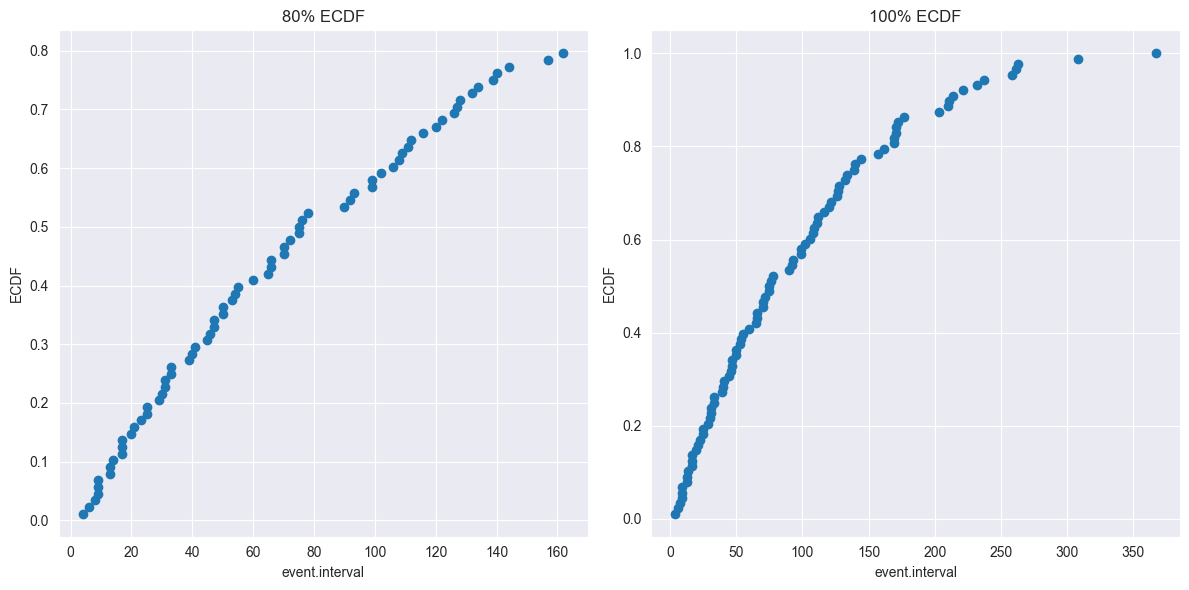

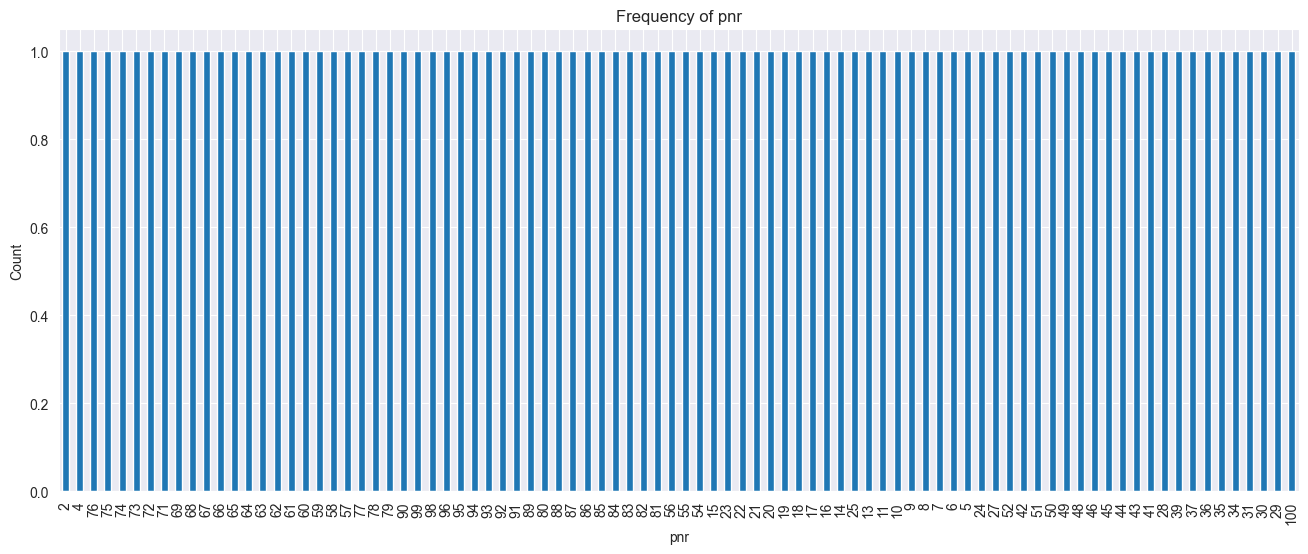

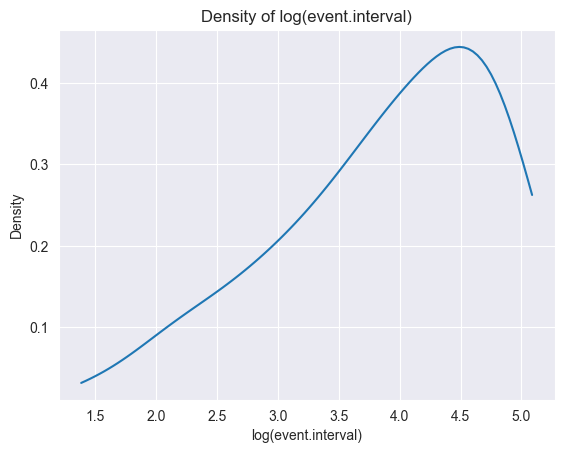

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,1,2033-04-26,4,medA,50,47.0,0.0
1,2,2036-01-20,4,medA,50,47.0,0.0
2,2,2036-03-10,4,medA,50,47.0,0.0
3,2,2036-08-01,4,medA,50,47.0,0.0
4,3,2042-04-13,4,medA,50,47.0,0.0


In [46]:
medA_see_kmc = See_KMeans('medA', simulated_df)

medA_see_kmc.head()

##### B. ATC = medB

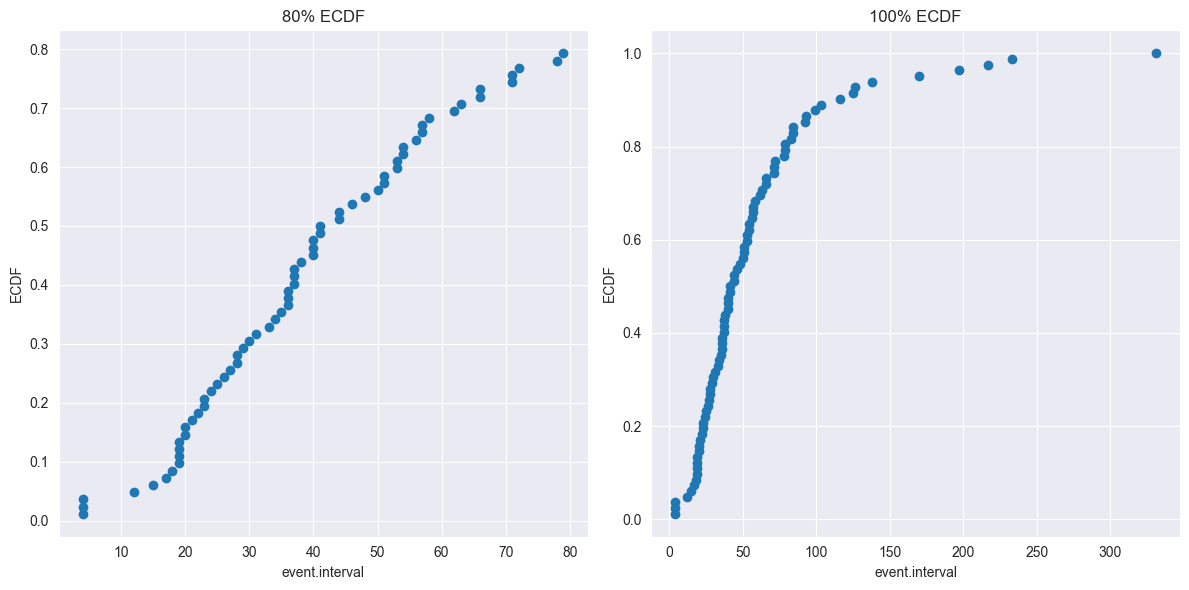

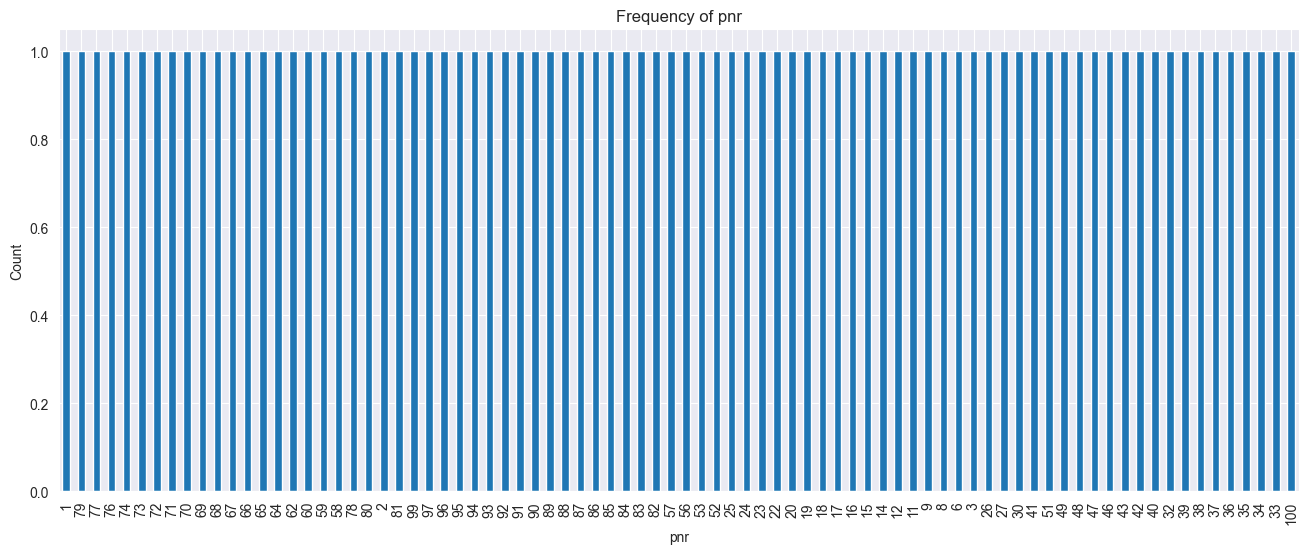

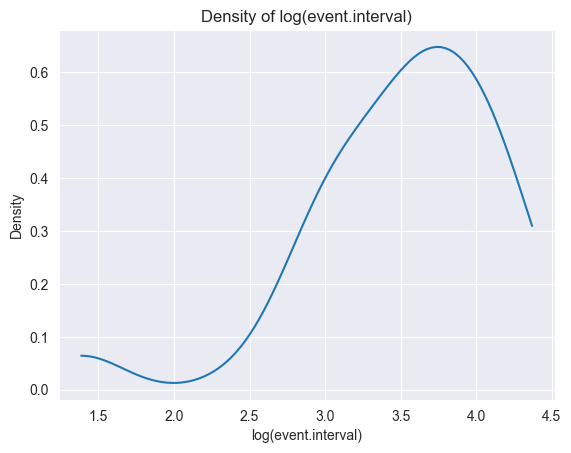

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,1,2033-07-04,4,medB,30,40.0,0.0
1,1,2033-08-03,4,medB,30,40.0,0.0
2,1,2033-08-17,4,medB,30,40.0,0.0
3,1,2033-10-13,4,medB,30,40.0,0.0
4,1,2033-10-16,4,medB,30,40.0,0.0


In [47]:
medB_see_kmc = See_KMeans('medB', simulated_df)

medB_see_kmc.head()

#### II. Sessa Empirical Estimator using DBSCAN

##### A. ATC = medA

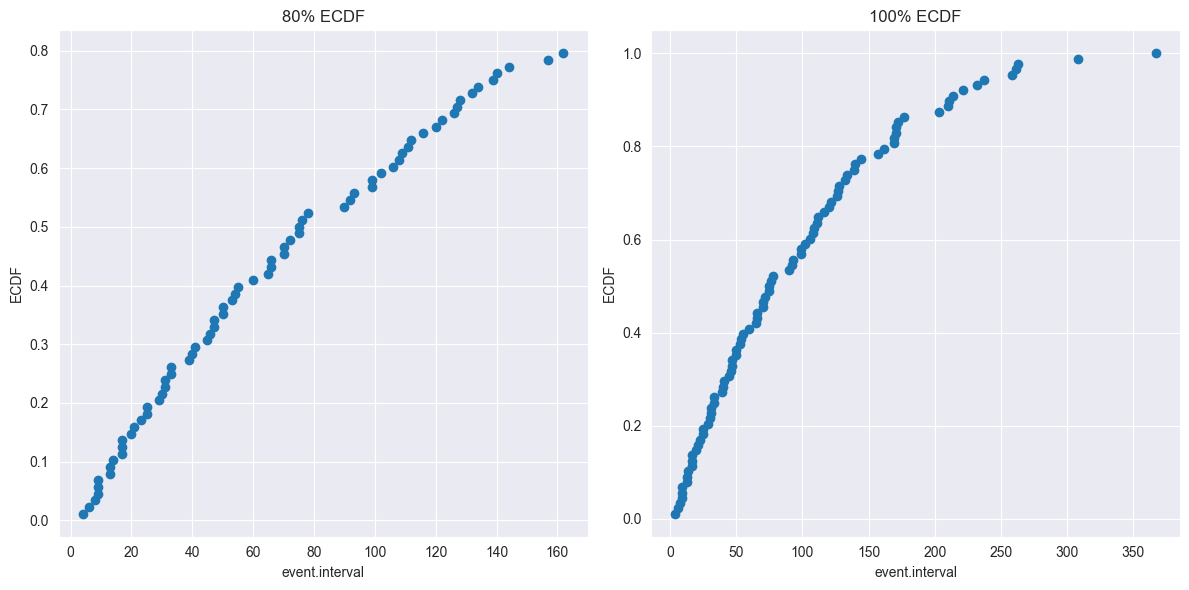

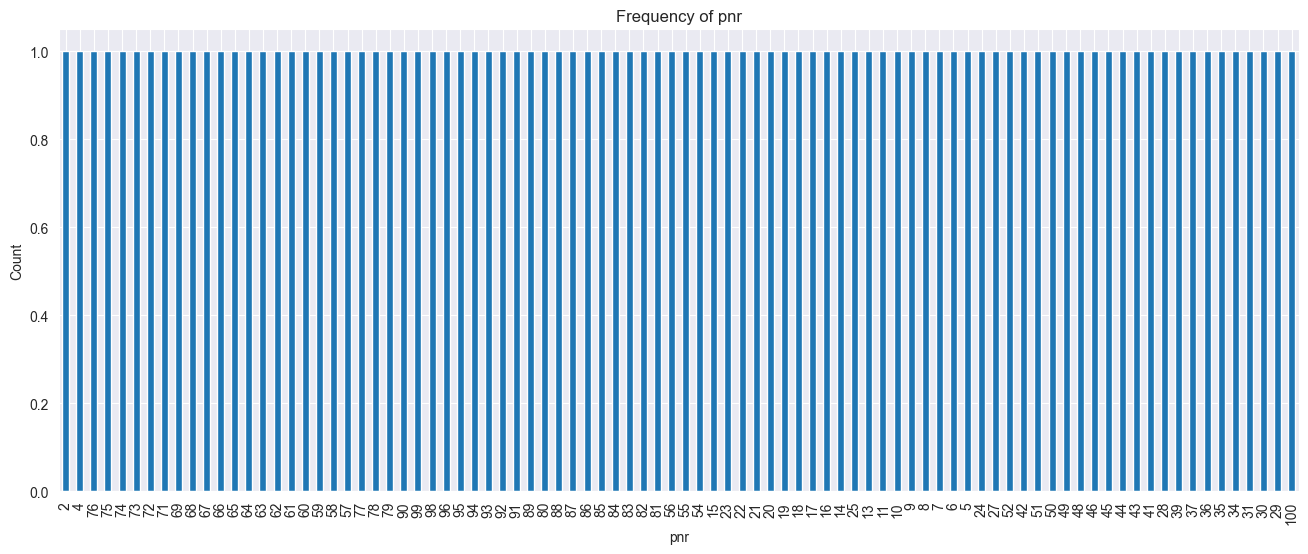

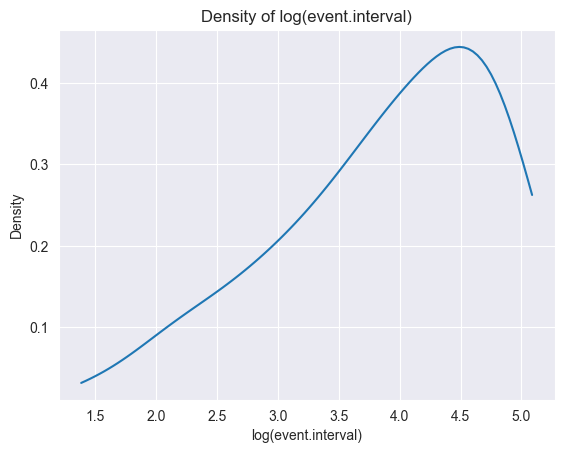

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,1,2033-04-26,4,medA,50,47.0,0.0
1,2,2036-01-20,4,medA,50,47.0,0.0
2,2,2036-03-10,4,medA,50,47.0,0.0
3,2,2036-08-01,4,medA,50,47.0,0.0
4,3,2042-04-13,4,medA,50,47.0,0.0
...,...,...,...,...,...,...,...
689,99,2031-11-08,4,medA,50,47.0,0.0
690,99,2032-06-16,4,medA,50,47.0,0.0
691,99,2032-09-18,4,medA,50,47.0,0.0
692,100,2032-08-05,2,medA,150,47.0,0.0


In [48]:
medA_see_dbscan = See_DBSCAN('medA', simulated_df)

medA_see_dbscan

##### B. ATC = medB

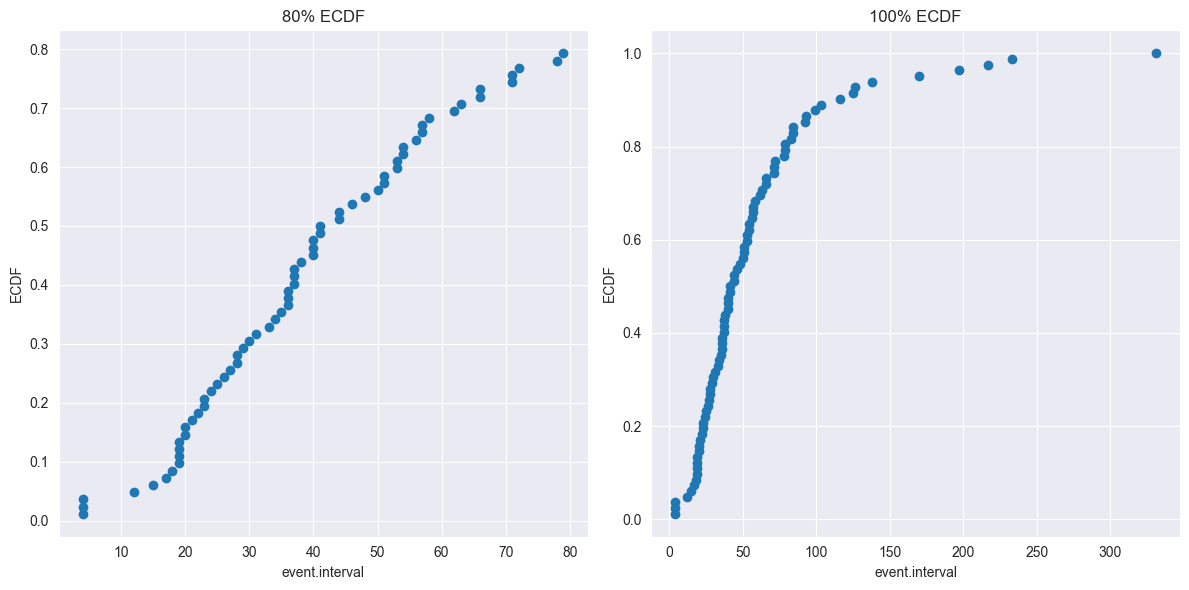

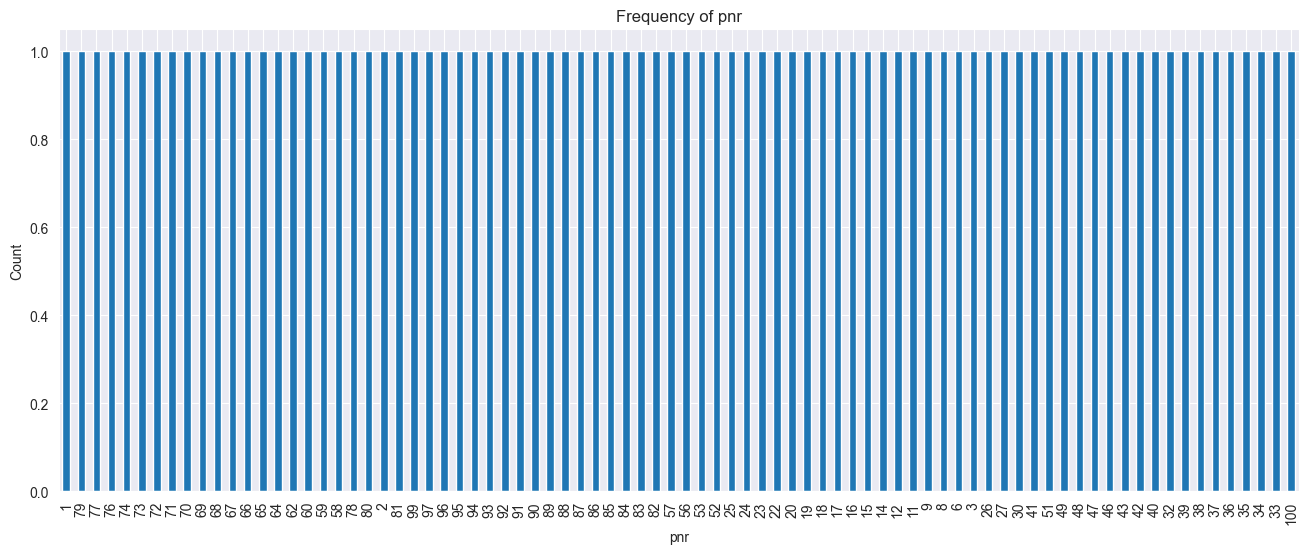

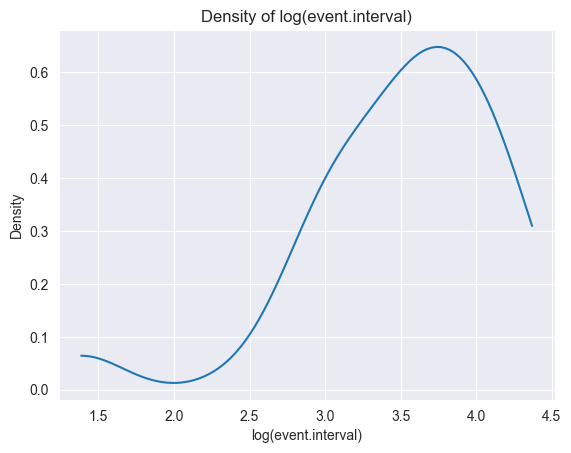

,pnr,eksd,perday,ATC,dur_original,Median,cluster
0,1,2033-07-04,4,medB,30,40.0,0.0
1,1,2033-08-03,4,medB,30,40.0,0.0
2,1,2033-08-17,4,medB,30,40.0,0.0
3,1,2033-10-13,4,medB,30,40.0,0.0
4,1,2033-10-16,4,medB,30,40.0,0.0


In [49]:
medB_see_dbscan = See_DBSCAN('medB', simulated_df)

medB_see_dbscan.head()

#### III. Assumption for Sessa Empirical Estimator using K Means

##### A. ATC = medA

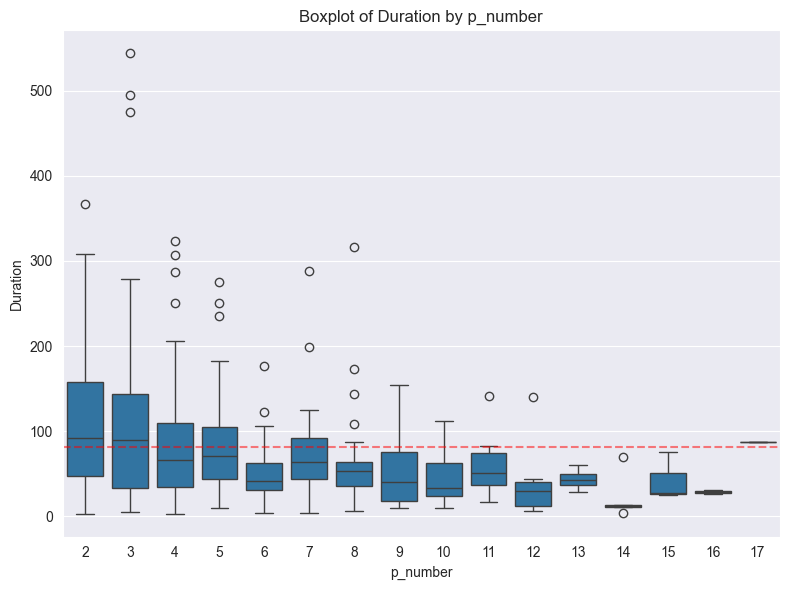

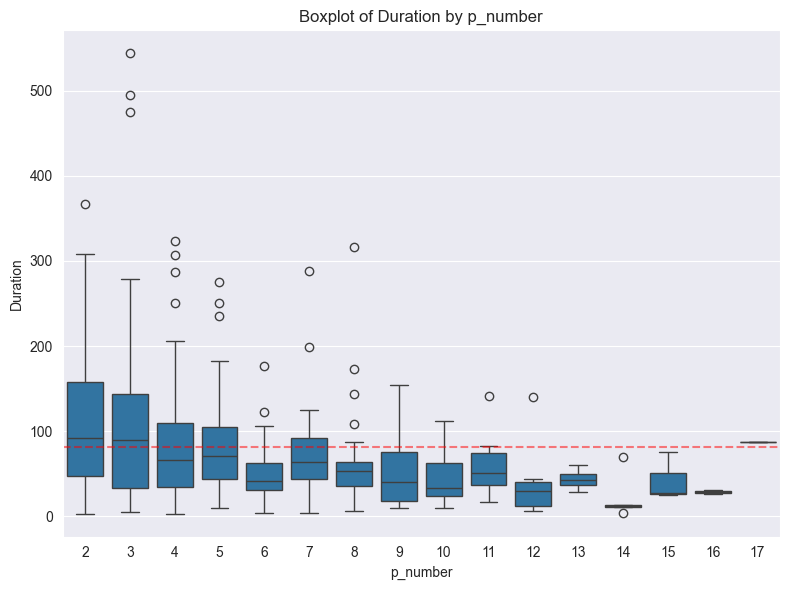

In [50]:
see_assumption(medA_see_kmc)

##### B. ATC = medB

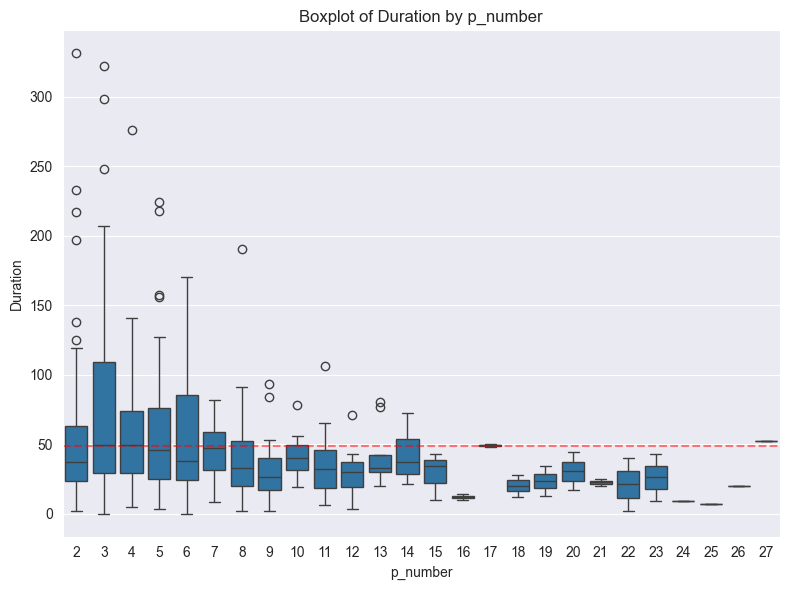

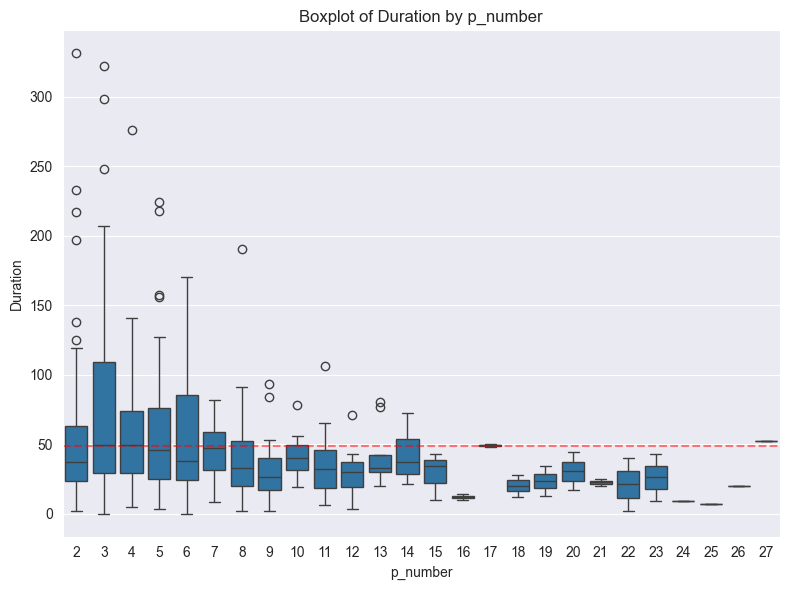

In [51]:
see_assumption(medB_see_kmc)

#### IV. Assumption for Sessa Empirical Estimator using DBSCAN

##### A. ATC = medA

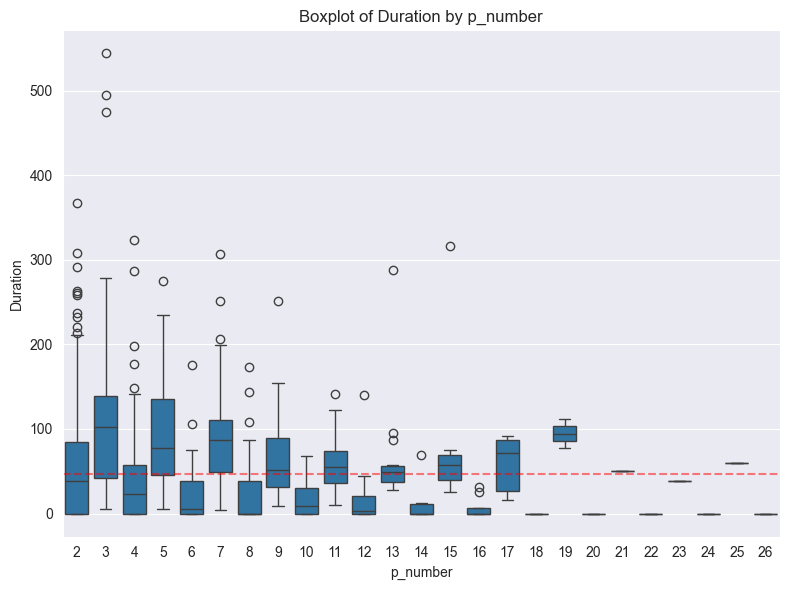

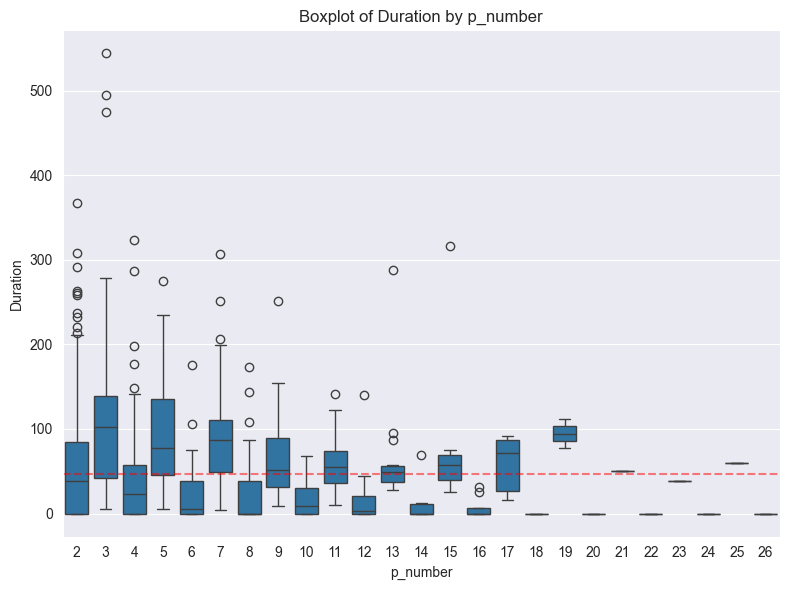

In [52]:
see_assumption(medA_see_dbscan)

##### B. ATC = medB

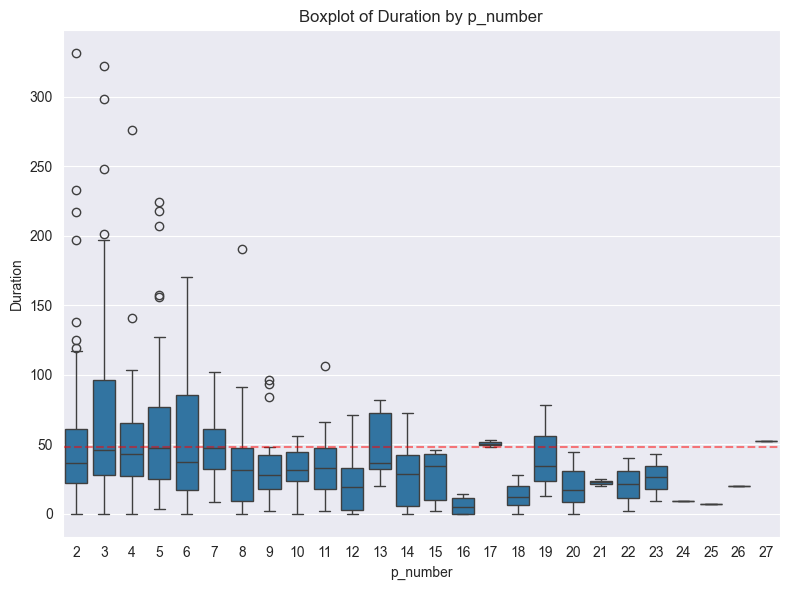

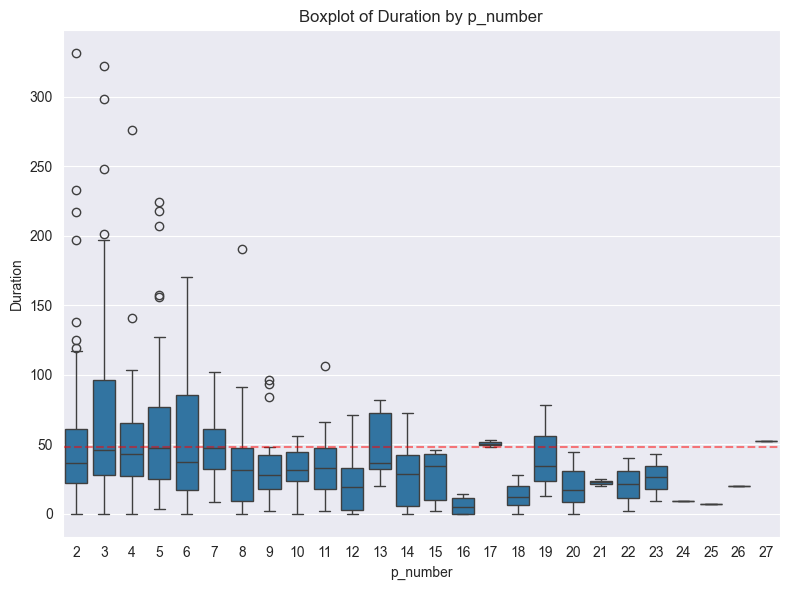

In [53]:
see_assumption(medB_see_dbscan)

### Observations From the SEE + KMeans Plots

#### A. Early Prescriptions Have Greater Variability

- In both medA and medB, the first few prescription numbers (e.g., p_number 2, 3, 4) show:
    - Large spreads in Duration values.
    - Outliers that can extend well above 100 days (in medA, up to ~500 days; in medB, up to ~300 days).
- This indicates that early refills are less predictable, potentially because patients are still establishing their medication routines.

#### B. Convergence in Later Prescriptions
- As p_number increases (e.g., beyond 10 for medA, beyond 15–20 for medB), the boxplots:
    - Become narrower, suggesting the refill intervals stabilize.
    - Have lower maximum durations and fewer extreme outliers.
- This pattern implies that patients tend to settle into more regular refill intervals after the initial few prescriptions.
#### C. Distinctions Between medA and medB
- Number of Prescriptions
    - medA: Up to 17 prescriptions are observed.
    - medB: Up to 27 prescriptions, indicating either longer treatment durations or more frequent refills.
- Overall Duration Range
    - medA: Outliers can reach 400–500 days early on, then settle below ~50–100 days.
    - medB: Outliers reach ~300 days, then drop to a steady range of ~20–60 days for later prescriptions.
- Median of Medians (the dashed red line)
    - The dashed line appears slightly higher for medA (somewhere in the ~50–60 day range).
    - For medB, it looks lower (around ~30–40 days).
    - This suggests medB patients, on average, have shorter refill intervals.

---

### Key Insights From the SEE + KMeans Plots
- Early Refill Irregularity
    - Both medA and medB show that first few refills have widely varying intervals. Clinicians or researchers might investigate why some patients go so long between the first and second prescriptions.
- Stabilization Over Time
    - For higher p_numbers, the intervals tighten considerably, reflecting more consistent adherence or regular refill schedules once patients are established on therapy.
- Different Refill Patterns by Medication
    - medB appears to have more total prescriptions and generally shorter intervals after the initial period. This could imply more frequent dosing or longer-term therapy.
    - medA shows fewer total refills but some extreme outliers in the earliest refills.
- Clinical or Operational Implications
    - Identifying Non-Adherence Early: Outliers in early p_number might indicate patients who are not following their regimen.
    - Forecasting Refill Demand: As patients progress, intervals become predictable, which can help with inventory management and patient follow-up.
    - Potential for Tailored Interventions: Patients whose refill intervals never stabilize (persistent outliers) might need extra support (e.g., reminders, counseling).

---

### Observations From the SEE + DBSCAN Plots

#### A. Early Prescriptions Have Greater Variability
- In both **medA** and **medB**, the first few prescription numbers (e.g., `p_number` 2, 3, 4) show:
  - Large spreads in **Duration** values.
  - Outliers that can extend to ~400–500 days in medA and ~300 days in medB.
- This indicates that **early refills** are less predictable, potentially because patients are still establishing their medication routines.

#### B. Convergence in Later Prescriptions
- As `p_number` increases (e.g., beyond ~8–10 for medA, beyond ~15–20 for medB), the boxplots:
  - Become **narrower**, suggesting that refill intervals stabilize.
  - Have **lower maximum durations** and fewer extreme outliers.
- This pattern implies that **patients tend to settle** into more regular refill intervals after the initial few prescriptions.

#### C. Distinctions Between medA and medB
- **Number of Prescriptions**
  - **medA**: Up to 26 prescription events observed.
  - **medB**: Up to 27 prescription events, indicating either longer treatment durations or more frequent refills for some patients.
- **Overall Duration Range**
  - **medA**: Early outliers can reach ~400–500 days, but later prescriptions typically fall below ~50–70 days.
  - **medB**: Early outliers reach ~300 days, then drop to a steady range of ~20–60 days for higher `p_number`.
- **Median of Medians (the dashed red line)**
  - Appears slightly higher for **medA** (somewhere around ~40–60 days).
  - Sits lower for **medB** (around ~30–40 days).
  - Suggests that medB patients, on average, have **shorter refill intervals** once they are on a stable regimen.

---

### Key Insights From the SEE + DBSCAN Plots
- **Early Refill Irregularity**
  - Both medA and medB show **highly variable intervals** for the first few refills. Investigating the reasons behind delayed second prescriptions could be crucial for understanding non-adherence.
- **Stabilization Over Time**
  - As `p_number` increases, refill intervals **tighten considerably**, pointing to more consistent adherence or routine refills once patients have settled into therapy.
- **Different Refill Patterns by Medication**
  - **medB** has more total prescriptions and converges to **shorter intervals** in later refills, possibly indicating frequent dosing or longer-term use.
  - **medA** exhibits fewer total refills but more extreme outliers in the early stages.
- **Clinical or Operational Implications**
  - **Identifying Non-Adherence Early**: Large outliers in early `p_number` may signal patients at risk of dropping off therapy.
  - **Forecasting Refill Demand**: As intervals become predictable, pharmacies can plan inventory more effectively.
  - **Tailored Interventions**: Patients whose intervals remain irregular (frequent outliers) might benefit from reminders, counseling, or other adherence strategies.


---


### Comparison: SEE + KMeans vs. SEE + DBSCAN

Both clustering methods are applied after the Sessa Empirical Estimator (SEE) to uncover patterns in prescription refill intervals, but they yield noticeably different outcomes—especially when comparing the number of boxplots and the nuances in refill behavior.


#### A. Early Prescriptions Variability

- **SEE + KMeans**
  - **medA:** Shows early boxplots (from `p_number` 2 onward) with wide ranges—outliers reaching up to ~500 days.
  - **medB:** Early prescriptions display considerable spread with outliers up to ~300 days.
  - **Interpretation:** The first few refills are highly variable for both medications, indicating patients are still establishing their refill routines.

- **SEE + DBSCAN**
  - **medA:** Maintains a similar pattern to KMeans in early prescriptions with high variability.
  - **medB:** Also shows significant early variability; however, the clustering process isolates outliers as noise, potentially sharpening the view of “typical” refill behavior.
  - **Interpretation:** Early variability remains evident, but DBSCAN’s robust treatment of outliers may provide a cleaner separation of typical intervals from irregular extremes.


#### B. Convergence in Later Prescriptions

- **SEE + KMeans**
  - **medA:** Boxplots converge after around `p_number` 10, with durations narrowing to under ~50–70 days.
  - **medB:** Convergence is observed after about `p_number` 15–20, with intervals settling in the ~20–60 day range.
  - **Interpretation:** Patients tend to adopt regular refill intervals as they progress through their prescriptions.

- **SEE + DBSCAN**
  - **medA:** A much larger number of boxplots (up to 26) are observed, revealing detailed nuances across a broader range of refill events. Later boxplots are tightly grouped, reflecting very stable refill behavior.
  - **medB:** Similar convergence is seen, with later prescriptions showing more consistent refill intervals.
  - **Interpretation:** DBSCAN reveals a finer stratification in long-term refill behavior for medB, highlighting that even within “stable” patterns, subtle differences exist.


#### C. Distinctions Between medA and medB

- **Number of Prescriptions (Boxplots)**
  - **KMeans:**
    - **medA:** Up to 17 prescription events.
    - **medB:** Up to 27 prescription events.
  - **DBSCAN:**
    - **medA:** Increases to 26, suggesting that DBSCAN uncovers more nuanced clusters within the refill data for medB.
    - **medB:** Remains at 17.
  - **Interpretation:** The dramatic increase in medB boxplots under DBSCAN implies that the refill patterns for medB are more heterogeneous; DBSCAN is better at separating dense regions from noise and thus differentiates more clusters than KMeans.

- **Overall Duration Range & Median of Medians**
  - **KMeans:**
    - **medA:** Early outliers reach ~400–500 days, with later medians around ~50–60 days.
    - **medB:** Outliers up to ~300 days, with later medians around ~30–40 days.
  - **DBSCAN:**
    - **medA:** Shows similar behavior.
    - **medB:** Although early variability is present, the exclusion of noise often results in a lower overall median (closer to ~30–40 days) due to the focus on denser, more representative refill intervals.
  - **Interpretation:** The median of medians remains a key benchmark. DBSCAN’s handling of outliers helps refine the median for medB by preventing extreme values from skewing the typical refill interval.


#### D. Key Insights & Implications

- **Early Refill Irregularity**
  - Both methods confirm that early refills are unpredictable.
  - **KMeans** forces every data point into a cluster, potentially blending irregularities.
  - **DBSCAN** isolates extreme refill intervals as noise, offering a cleaner picture of typical behavior.

- **Stabilization Over Time**
  - With both methods, later prescriptions converge to stable refill intervals.
  - **DBSCAN** uncovers additional layers of detail for medB, suggesting that even within stable patterns, there are subgroups with subtly different behaviors.

- **Different Refill Patterns by Medication**
  - **medA:** Exhibits a broader range of refill events under DBSCAN (26 vs. 17 boxplots), indicating either a more complex refill regimen or longer-term usage that is more granularly segmented by DBSCAN.
  - **medB:** Consistent results between the two methods, with fewer overall prescriptions and higher early variability.

- **Clinical/Operational Implications**
  - **For KMeans:** A fixed number of clusters simplifies interpretation and is useful when a predetermined grouping is desired.
  - **For DBSCAN:** Automatic detection of clusters and noise provides a more nuanced view, which can be critical in identifying subtle patterns in adherence—especially in medications with a prolonged refill history like medB.
  - Tailored interventions can be designed depending on whether outliers (non-adherence) are clearly isolated (as in DBSCAN) or if they are absorbed into broader clusters (as in KMeans).


#### Final Thoughts

- **SEE + KMeans** provides a more straightforward, fixed-cluster view of prescription behavior, suitable for summarizing general refill trends.
- **SEE + DBSCAN** offers a richer, more detailed segmentation, particularly for medA, where the higher number of clusters may reflect more complex and heterogeneous long-term refill patterns.
- The choice between these methods depends on whether simplicity or nuanced detail is prioritized for downstream decision-making."
